In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local_new import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import corner

In [4]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data 
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[4])}")


Length of the first datax array: 878


In [5]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)


[0.2, 0.25, 0.25, 0.2, 0.2, 0.2]


In [6]:
# set up the class
cluster = ClusterLensing_fyp(datax_list, datay_list, data_psi_list, 0.5, 1, pixscale_list, diff_z=False)


In [5]:
# check with the lenstronomy package directly
realsize = 678
grid = np.linspace(0, realsize-1, realsize)
grid = grid * 0.25

lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [{'grid_interp_x': grid, 'grid_interp_y': grid, 'f_': data_psi_list[1]*0.25**2,
                          'f_x': datax_list[1], 'f_y': datay_list[1]}]
lensModel_real = LensModel(lens_model_list=lens_model_list2, z_source=1, z_lens=0.5,  cosmo=FlatLambdaCDM(H0=70, Om0=0.3))

# Use lens equation solver for verification
solver2 = LensEquationSolver(lensModel_real)
coord = (63.8, 84.1)
img_po = solver2.image_position_from_source(coord[0], coord[1], kwargs_lens2, min_distance=0.25, search_window=100, verbose=False, x_center=75, y_center=80)
print(img_po)

arrival_time = lensModel_real.arrival_time(img_po[0], img_po[1], kwargs_lens2)
arrival_time = arrival_time - arrival_time.min()
print(arrival_time)


(array([25.04527574, 80.3895084 , 89.83823507, 70.3500693 , 62.87531747,
       63.56479705, 78.41485862]), array([96.30394225, 51.47812429, 71.45908221, 59.92729871, 45.81923451,
       52.27263524, 72.34180586]))
[    0.         85650.5533709  88747.053469   88842.72641592
 89060.09352025 89475.68135987 90426.03457397]


In [ ]:
# mixed mcmc and DE
parameters = [80.5,74.0,3.2,0] # x, y, z, index
dt_obs = cluster.my_image_and_delay_for_xyz(parameters[0], parameters[1], parameters[2], parameters[3])[2]
print("True time delays:", dt_obs)

de_solution, mcmc_solution, sampler, samples = cluster.localize_diffevo_then_mcmc_known_cluster(
    dt_true=dt_obs,
    index=parameters[3],
    # DE settings
    early_stop=5e4,
    # MCMC settings
    n_walkers=21, n_steps=1500, burn_in=800,
                               x_range_prior=10.0, y_range_prior=10.0,
                               z_lower=2, z_upper=3.5,
                               sigma=0.05,
                               n_processes=12
)

print("DE solution:", de_solution)
print("MCMC median:", mcmc_solution)
#print("samples shape:", samples.shape)

True time delays: [   0.         4882.33565976 5921.21271887 6388.26346622 6592.76233585
 6775.13536243]
differential_evolution step 1: f(x)= 1400000000000.0
differential_evolution step 2: f(x)= 6781420139.153417


Process ForkPoolWorker-14:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-22:
Process ForkPoolWorker-5:
Process ForkPoolWorker-24:
Process ForkPoolWorker-13:
Process ForkPoolWorker-2:
Process ForkPoolWorker-18:
Process ForkPoolWorker-9:
Process ForkPoolWorker-1:
Process ForkPoolWorker-12:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-21:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent

EOFError: Ran out of input

In [ ]:
index, xyz= 1, [67.5,81,3]

x_img, y_img, dt = cluster.my_image_and_delay_for_xyz(67.5,81,3.1, index=1)
print("Image positions =", x_img, y_img)
print("Time delays     =", dt)

In [ ]:
# de + mcmc with unknown cluster

parameters = [80.1,99.9,3.3, 4] # x, y, z, index
dt_obs = cluster.my_image_and_delay_for_xyz(parameters[0], parameters[1], parameters[2], parameters[3])[2]
print("True time delays:", dt_obs)

opt_index, opt_pos, opt_chi_sq, sampler, samples = cluster.localize_diffevo_then_mcmc(
    dt_true=dt_obs,
    # DE settings
    early_stop=5e4,
    # MCMC settings
    n_walkers=12, n_steps=2500, burn_in=1500,
                               x_range_prior=10.0, y_range_prior=10.0,
                               z_lower=2, z_upper=3.5,
                               sigma=0.05,
                               n_processes=12
)

print("Best fit parameters:", opt_pos)
print("Optimized Chi squared value:", opt_chi_sq)
print("samples shape:", samples.shape)

src = pd.read_csv('src_pos_for_dist_with_z_de+mcmc.csv')
src.at[i, 'indices'] = parameters[3]
src.at[i, 'x'] = parameters[0]
src.at[i, 'y'] = parameters[1]
src.at[i, 'z'] = parameters[2]
src.at[i, 'localized_index'] = opt_index
src.at[i, 'localized_x'] = opt_pos[0]
src.at[i, 'localized_y'] = opt_pos[1]
src.at[i, 'localized_z'] = opt_pos[2]
src.at[i, 'localized_chi_sq'] = opt_chi_sq
src.to_csv('src_pos_for_dist_with_z_de+mcmc.csv', index=False)

True time delays: [    0.         63511.36869834 74572.75260626 74999.14298262
 80795.70605133]
differential_evolution step 1: f(x)= 755666911907.0187
differential_evolution step 2: f(x)= 755666911907.0187
differential_evolution step 3: f(x)= 755666911907.0187
differential_evolution step 4: f(x)= 755666911907.0187
differential_evolution step 5: f(x)= 755666911907.0187
differential_evolution step 6: f(x)= 755666911907.0187
differential_evolution step 7: f(x)= 755666911907.0187
differential_evolution step 8: f(x)= 755666911907.0187
differential_evolution step 9: f(x)= 755666911907.0187
differential_evolution step 10: f(x)= 755666911907.0187
differential_evolution step 11: f(x)= 755666911907.0187
differential_evolution step 12: f(x)= 755666911907.0187
differential_evolution step 13: f(x)= 755666911907.0187
differential_evolution step 14: f(x)= 640696148110.4741
differential_evolution step 15: f(x)= 640696148110.4741
differential_evolution step 16: f(x)= 640696148110.4741
differential_evol

100%|██████████| 2500/2500 [3:20:42<00:00,  4.82s/it]  


MCMC median after DE: x=80.10, y=99.90, z=3.30
Replaced original opt.
differential_evolution step 1: f(x)= 2800000000000.0
differential_evolution step 2: f(x)= 2800000000000.0
differential_evolution step 3: f(x)= 2800000000000.0
differential_evolution step 4: f(x)= 2800000000000.0
differential_evolution step 5: f(x)= 2800000000000.0
differential_evolution step 6: f(x)= 2505133341644.727
differential_evolution step 7: f(x)= 2505133341644.727
differential_evolution step 8: f(x)= 2438014423602.199
differential_evolution step 9: f(x)= 2438014423602.199
differential_evolution step 10: f(x)= 2438014423602.199
differential_evolution step 11: f(x)= 2396319257323.809
differential_evolution step 12: f(x)= 1797427120432.9248
differential_evolution step 13: f(x)= 1797427120432.9248
differential_evolution step 14: f(x)= 1797427120432.9248
differential_evolution step 15: f(x)= 1797427120432.9248
differential_evolution step 16: f(x)= 1797427120432.9248
differential_evolution step 17: f(x)= 1797427120

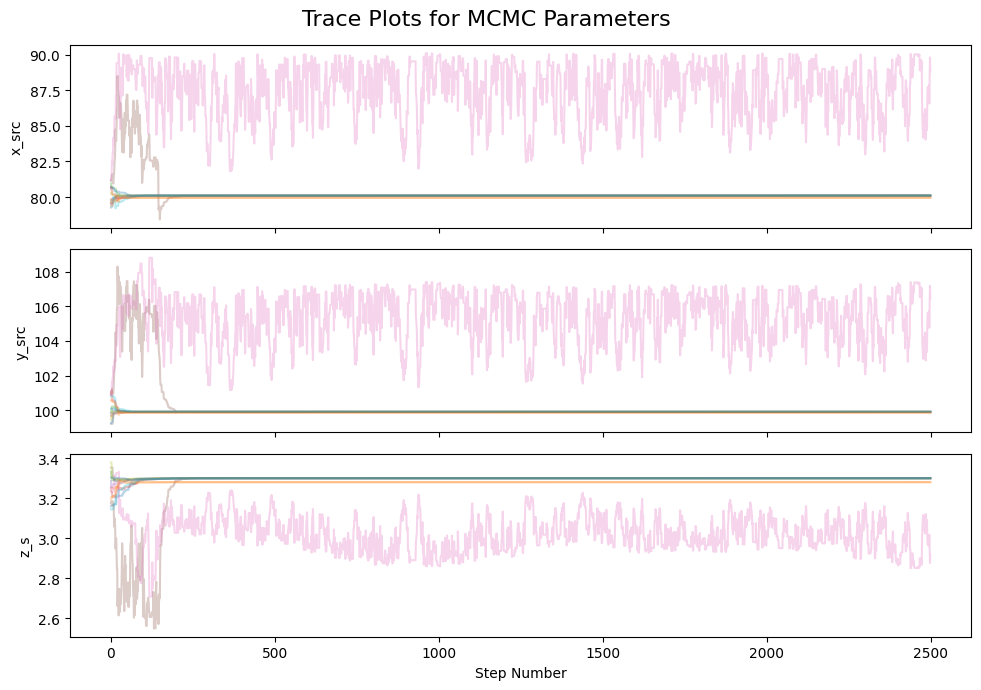

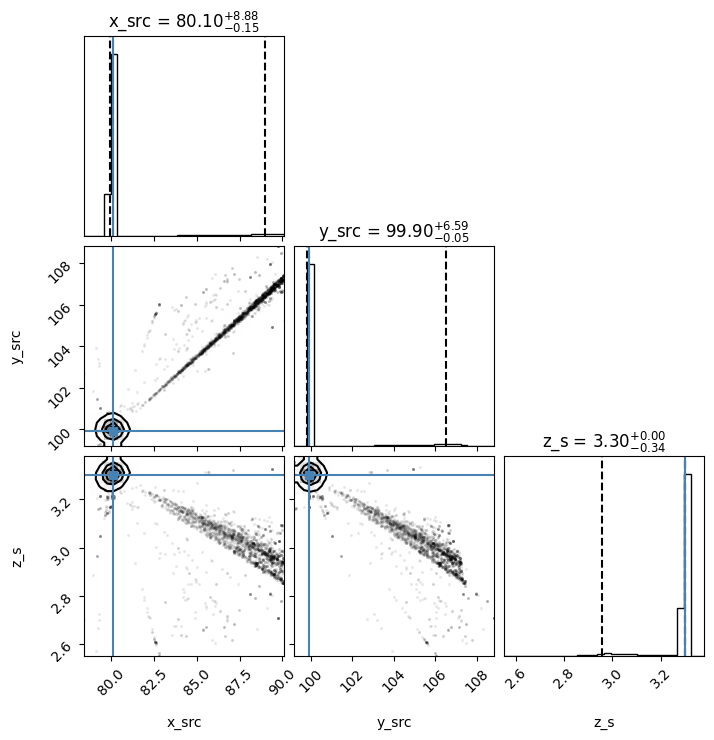

In [7]:
# Assuming sampler is your emcee sampler object and burn_in is defined.
# Retrieve the chain; shape: (n_steps, n_walkers, ndim)
burn_in = 1500
chain = sampler.get_chain(flat=False)
log_probs = sampler.get_log_prob(discard=burn_in, flat=True)
n_steps, n_walkers, ndim = chain.shape
labels = ["x_src", "y_src", "z_s"]

# --- Plot Trace Plots ---
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(n_walkers):
        ax.plot(chain[:, walker, i], alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step Number")
plt.suptitle("Trace Plots for MCMC Parameters", fontsize=16)
plt.tight_layout()
#plt.savefig('de_mcmc/de_mcmc_trace_fixz.pdf')
plt.show()

# --- Plot Corner Plot ---
# Flatten the chain (each walker’s chain concatenated) after burn-in.
flat_samples = sampler.get_chain(flat=True)

figure = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.025, 0.5, 0.975],  # 95% interval
    show_titles=True,
    truths=[parameters[0], parameters[1], parameters[2]],  # True values
    smooth=1.0,  # Smooth out contours
    bins=30,     # Increase the number of bins
)

#plt.savefig('de_mcmc/de_mcmc_corner_fixz.pdf')
plt.show()


In [8]:
print(np.mean(sampler.acceptance_fraction))

0.25093333333333334


In [9]:
samples = sampler.get_chain(discard=burn_in, flat=True)  # shape: (n_samples, n_dim)

# 2) Retrieve the corresponding log-prob values for each sample
log_probs = sampler.get_log_prob(discard=burn_in, flat=True)  # shape: (n_samples,)

# 3) Find the index of the maximum log-likelihood
best_idx = np.argmax(log_probs)

# 4) Extract the parameter set with the largest log-likelihood
best_params = samples[best_idx]
best_chi_sq = cluster.chi_squared_with_z(best_params, dt_obs, index=0)

print(f"Best-fitting parameters = {best_params}")
print(f"Optimized chi-squared   = {best_chi_sq}")

Best-fitting parameters = [80.09999281 99.90000066  3.3000009 ]
Optimized chi-squared   = 10000000000000.0


In [10]:
tau = sampler.get_autocorr_time()
print("Autocorr times:", tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [30.42458751 30.03124449 63.52645014]

In [14]:

#print(dt_obs)
print(cluster.my_image_and_delay_for_xyz(80.1,99.9,3.3,4)[2])
#chisq = cluster.chi_squared_with_z([70.01320813, 75.02377333,  3.11390395], dt_obs, index=1)
#print("Chi squared value:", chisq)

[    0.         63511.36869834 74572.75260626 74999.14298262
 80795.70605133]
